# ELU 502 Deep learning -- Lab session 5
Pierre-Henri Conze, François Rousseau, Ronan Fablet - session: 1h20 (17th april)+3h (20th april)

### Objectives: perform classification on Fashion-MNIST dataset using multiple layer perceptrons, convolutional neural networks, data augmentation and transfer learning to obtain the best classification results as possible!

First, download and read the Fashion-MNIST data.

In [70]:
%matplotlib inline
import keras
from keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

### Part 1 - Data management and visualization

#### 1) Fashion-MNIST is a dataset consisting of a training set of A examples and a test set of B examples. Each example is a CxC grayscale image, associated with a label from D classes. What are the values for A, B, C and D?

In [71]:
import numpy as np
print('x_train shape:', x_train.shape, 'x_test shape:', x_test.shape)
print(x_train.shape[0], 'train samples (A)')
print(x_test.shape[0], 'test samples (B)')
print(x_test[0,:,:].shape, 'image size (C)')
print(len(np.unique(y_test)), 'number of classes (D)')


x_train shape: (60000, 28, 28) x_test shape: (10000, 28, 28)
60000 train samples (A)
10000 test samples (B)
(28, 28) image size (C)
10 number of classes (D)


Each training/test sample is assigned to one of the following labels: 
0	T-shirt
1	Trouser
2	Pullover
3	Dress
4	Coat
5	Sandal
6	Shirt
7	Sneaker
8	Bag
9	Ankle boot

In [72]:
num_classes = 10
class_names = ['tshirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'boot']

#### 2) Visualize one example per class among the training dataset:

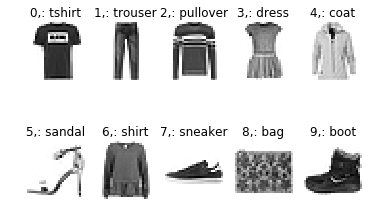

In [73]:
import matplotlib.pyplot as plt

plt.figure() #new figure
for i in range(num_classes):
    plt.subplot(2, 5, i + 1)
    plt.axis('off')
    index = np.where(y_train == i)[0][0] #select image from different class
    plt.imshow(x_train[index,:,:],cmap=plt.cm.gray_r)
    plt.title('%i,: %s' %(y_train[index],class_names[i]))
plt.show()

### Part 2 - Multi-layer perceptrons

#### 3) Define a simple Keras multi-layer perceptron (MLP) architecture using Sequential API and containing 3 dense layers: 2 dense layers with 512 units and ReLU activation followed by 1 dense layer for softmax regression. Use your model to get first classification results on Fashion MNIST.

In [74]:
num_classes = 10

In [75]:
from keras.models import Sequential
from keras.layers import Dense, Dropout,Flatten
from keras.optimizers import RMSprop

In [76]:
mlp_1 = Sequential()
(img_rows,img_cols)=x_test[0,:,:].shape
input_shape = (img_rows,img_cols,1)
layer = [Dense(512,activation='relu',input_shape = input_shape), #must indicate input_shape first time
         Dense(512,activation='relu'),
         Flatten(), #to flatten the input array; always
         Dense(num_classes,activation='softmax')]
#add layer to model
for i in layer:
    mlp_1.add(i)
    

# hist_mlp_1 = mlp_1.fit(...)

In [77]:
from keras.optimizers import RMSprop
mlp_1.compile(loss='categorical_crossentropy', optimizer = RMSprop(),metrics=['accuracy'])

mlp_1.summary() #model info

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 28, 28, 512)       1024      
_________________________________________________________________
dense_35 (Dense)             (None, 28, 28, 512)       262656    
_________________________________________________________________
flatten_12 (Flatten)         (None, 401408)            0         
_________________________________________________________________
dense_36 (Dense)             (None, 10)                4014090   
Total params: 4,277,770
Trainable params: 4,277,770
Non-trainable params: 0
_________________________________________________________________


Before we need normalize the dataset and obtain vector categorical

In [78]:
batch_size = 128 #c'est la quantité d'image que prend chaque fois
epochs = 12

# build 4D tensors
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
# data normalization
x_train = x_train.astype('float32')/x_train.max()
x_test = x_test.astype('float32')/x_test.max()
# convert class vectors to binary class matrices
z_train = keras.utils.to_categorical(y_train, num_classes)
z_test = keras.utils.to_categorical(y_test, num_classes)


In [79]:
#ajusta el modelo
print(x_train.shape)
#ajusta el modelo
print(z_train.shape)

(60000, 28, 28, 1)
(60000, 10)


In [80]:
#Fit model
history = mlp_1.fit(x_train,z_train, validation_data=(x_test,z_test), epochs=epochs,batch_size=batch_size)

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 30s 505us/step - loss: 0.5388 - acc: 0.8077 - val_loss: 0.4583 - val_acc: 0.8382
Epoch 2/12
60000/60000 [==============================] - 30s 499us/step - loss: 0.4072 - acc: 0.8523 - val_loss: 0.4450 - val_acc: 0.8413
Epoch 3/12
60000/60000 [==============================] - 30s 506us/step - loss: 0.3760 - acc: 0.8648 - val_loss: 0.4050 - val_acc: 0.8588
Epoch 4/12
60000/60000 [==============================] - 31s 516us/step - loss: 0.3563 - acc: 0.8727 - val_loss: 0.4368 - val_acc: 0.8442
Epoch 5/12
60000/60000 [==============================] - 31s 522us/step - loss: 0.3454 - acc: 0.8766 - val_loss: 0.3913 - val_acc: 0.8590
Epoch 6/12
60000/60000 [==============================] - 32s 536us/step - loss: 0.3326 - acc: 0.8822 - val_loss: 0.3933 - val_acc: 0.8614
Epoch 7/12
60000/60000 [==============================] - 32s 533us/step - loss: 0.3241 - acc: 0.8841 - val_loss: 0.

#### 4) Define a generic function evaluate_model() able to:
- plot the evolution of accuracy for both training and testing data with respect to the epochs
- compute final test loss and accuracy. 

Use this function to assess the performance of the previously defined model.

In [81]:
def evaluate_model(model,history,x_test,z_test):
    #Plot evolution of accuracy 
    print(history.history.keys()) 
    plt.figure()
    plt.plot(history.history['acc']) #accuracy en training
    plt.plot(history.history['val_acc']) #accuracy en validation
    plt.title('model acc')
    plt.ylabel('acc')  
    plt.xlabel('epochs')
    plt.legend(['train','val'], loc='upper left')
    plt.show()
    
    score = model.evaluate(x_test, z_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


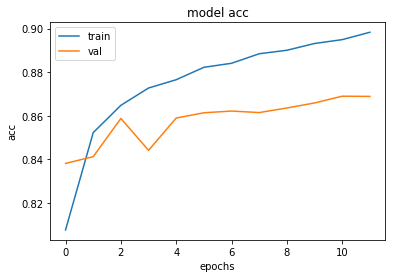

Test loss: 0.39063703944683076
Test accuracy: 0.8689


In [82]:
# evaluate_model(mlp_1,...)
evaluate_model(mlp_1,history,x_test, z_test)

Comment: This model has more than 4 millions-parameter to fit, after 12 epo

#### 5) Define a deeper multi-layer perceptron (MLP) architecture to outperform the previously obtained classification results. 
Use evaluate_model() to provide the evaluation and comment the performance.

In [83]:
mlp_2 = Sequential()

layer_2 = [Dense(512,activation='relu',input_shape = input_shape), #must indicate input_shape first time
         Dense(512,activation='relu'),
         Dense(256,activation='relu'), #new layer
         Flatten(), #to flatten the input array; always
         Dense(num_classes,activation='softmax')]
#add layer to model
for i in layer_2:
    mlp_2.add(i)
    
#compile
mlp_2.compile(loss='categorical_crossentropy', optimizer = RMSprop(),metrics=['accuracy'])

mlp_2.summary() #model info

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 28, 28, 512)       1024      
_________________________________________________________________
dense_38 (Dense)             (None, 28, 28, 512)       262656    
_________________________________________________________________
dense_39 (Dense)             (None, 28, 28, 256)       131328    
_________________________________________________________________
flatten_13 (Flatten)         (None, 200704)            0         
_________________________________________________________________
dense_40 (Dense)             (None, 10)                2007050   
Total params: 2,402,058
Trainable params: 2,402,058
Non-trainable params: 0
_________________________________________________________________


In [84]:
history_2 = mlp_2.fit(x_train,z_train, validation_data=(x_test,z_test), epochs=epochs,batch_size=batch_size)

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 40s 665us/step - loss: 0.5412 - acc: 0.8043 - val_loss: 0.4932 - val_acc: 0.8101
Epoch 2/12
60000/60000 [==============================] - 41s 677us/step - loss: 0.3926 - acc: 0.8578 - val_loss: 0.4249 - val_acc: 0.8484
Epoch 3/12
60000/60000 [==============================] - 41s 677us/step - loss: 0.3614 - acc: 0.8705 - val_loss: 0.3958 - val_acc: 0.8613
Epoch 4/12
60000/60000 [==============================] - 41s 679us/step - loss: 0.3411 - acc: 0.8779 - val_loss: 0.4015 - val_acc: 0.8586
Epoch 5/12
60000/60000 [==============================] - 41s 677us/step - loss: 0.3244 - acc: 0.8832 - val_loss: 0.4000 - val_acc: 0.8609
Epoch 6/12
60000/60000 [==============================] - 41s 677us/step - loss: 0.3102 - acc: 0.8890 - val_loss: 0.3888 - val_acc: 0.8656
Epoch 7/12
60000/60000 [==============================] - 41s 681us/step - loss: 0.2975 - acc: 0.8938 - val_loss: 0.

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


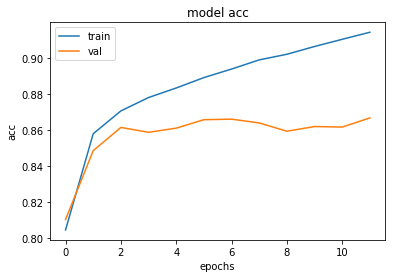

Test loss: 0.42411673035621644
Test accuracy: 0.8666


In [85]:
evaluate_model(mlp_2,history_2,x_test, z_test)

### Part 3 - Convolutional neural networks

##### 6) Define a simple Keras convolutional neural network (CNN) architecture using Sequential API and containing the following layers : 1 convolution layer using Conv2D and 32 filters, 1 max-polling layer using MaxPooling2D, 2 dense layers using ReLU and softmax activations respectively. Use this model to get classification results (use evaluate_model() as previously) and compared them to MLP results. 

In [86]:
from keras.layers import Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K


In [87]:
cnn_1 = Sequential()

layer = [Conv2D(32,kernel_size = (3,3), activation='relu',input_shape = input_shape,strides = (1,1)),
         MaxPooling2D(pool_size=(2, 2)), #nucleo del CNN
         Flatten(),
         Dense(128,activation='relu'),
         Dense(128,activation='relu'),
         Dense(num_classes,activation='softmax')] #probabilidad de pertenencia a la clase 
#add layer to model
for i in layer:
    cnn_1.add(i)

#compile
cnn_1.compile(loss='categorical_crossentropy', optimizer = RMSprop(),metrics=['accuracy'])
#summary
cnn_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 5408)              0         
_________________________________________________________________
dense_41 (Dense)             (None, 128)               692352    
_________________________________________________________________
dense_42 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_43 (Dense)             (None, 10)                1290      
Total params: 710,474
Trainable params: 710,474
Non-trainable params: 0
_________________________________________________________________


In [88]:
#Fit model
history_cnn_1 = cnn_1.fit(x_train,z_train, validation_data=(x_test,z_test), epochs=epochs,batch_size=batch_size)

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 3s 49us/step - loss: 0.4927 - acc: 0.8224 - val_loss: 0.3474 - val_acc: 0.8748
Epoch 2/12
60000/60000 [==============================] - 2s 41us/step - loss: 0.2962 - acc: 0.8927 - val_loss: 0.2823 - val_acc: 0.8955
Epoch 3/12
60000/60000 [==============================] - 2s 41us/step - loss: 0.2456 - acc: 0.9090 - val_loss: 0.2900 - val_acc: 0.8935
Epoch 4/12
60000/60000 [==============================] - 2s 42us/step - loss: 0.2104 - acc: 0.9228 - val_loss: 0.2717 - val_acc: 0.8985
Epoch 5/12
60000/60000 [==============================] - 2s 42us/step - loss: 0.1854 - acc: 0.9313 - val_loss: 0.2579 - val_acc: 0.9095
Epoch 6/12
60000/60000 [==============================] - 2s 41us/step - loss: 0.1637 - acc: 0.9389 - val_loss: 0.2601 - val_acc: 0.9090
Epoch 7/12
60000/60000 [==============================] - 2s 41us/step - loss: 0.1419 - acc: 0.9473 - val_loss: 0.2768 - val_acc

Evaluate the new model

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


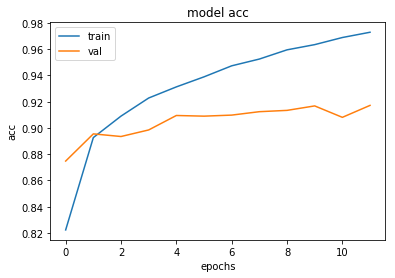

Test loss: 0.3236405785933137
Test accuracy: 0.9172


In [89]:
evaluate_model(cnn_1,history_cnn_1,x_test, z_test)

#### 7) As for MLP, define a deeper CNN architecture to outperform the previously obtained classification results. What are your conclusions?

In [90]:
cnn_2 = Sequential()

layer = [Conv2D(32,kernel_size = (3,3), activation='relu',input_shape = input_shape,strides = (1,1)),
         Conv2D(32,kernel_size = (3,3), activation='relu'),
         MaxPooling2D(pool_size=(2, 2)), #nucleo del CNN New layer
         Flatten(),
         Dense(128,activation='relu'),
         Dense(128,activation='relu'),
         Dense(num_classes,activation='softmax')] #probabilidad de pertenencia a la clase 
#add layer to model
for i in layer:
    cnn_2.add(i)

#compile
cnn_2.compile(loss='categorical_crossentropy', optimizer = RMSprop(),metrics=['accuracy'])
#summary
cnn_2.summary()

# cnn_2.add(...)
# to do 
# evaluate_model(...)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 4608)              0         
_________________________________________________________________
dense_44 (Dense)             (None, 128)               589952    
_________________________________________________________________
dense_45 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_46 (Dense)             (None, 10)                1290      
Total para

In [91]:
#Fit model
history_cnn_2 = cnn_2.fit(x_train,z_train, validation_data=(x_test,z_test), epochs=epochs,batch_size=batch_size)

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 4s 62us/step - loss: 0.4684 - acc: 0.8275 - val_loss: 0.3273 - val_acc: 0.8817
Epoch 2/12
60000/60000 [==============================] - 3s 54us/step - loss: 0.2796 - acc: 0.8990 - val_loss: 0.2793 - val_acc: 0.8936
Epoch 3/12
60000/60000 [==============================] - 3s 54us/step - loss: 0.2209 - acc: 0.9192 - val_loss: 0.2576 - val_acc: 0.9033
Epoch 4/12
60000/60000 [==============================] - 3s 54us/step - loss: 0.1826 - acc: 0.9337 - val_loss: 0.2358 - val_acc: 0.9160
Epoch 5/12
60000/60000 [==============================] - 3s 54us/step - loss: 0.1519 - acc: 0.9445 - val_loss: 0.2279 - val_acc: 0.9199
Epoch 6/12
60000/60000 [==============================] - 3s 54us/step - loss: 0.1247 - acc: 0.9540 - val_loss: 0.2487 - val_acc: 0.9149
Epoch 7/12
60000/60000 [==============================] - 3s 54us/step - loss: 0.1017 - acc: 0.9622 - val_loss: 0.2766 - val_acc

Evaluate model 2

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


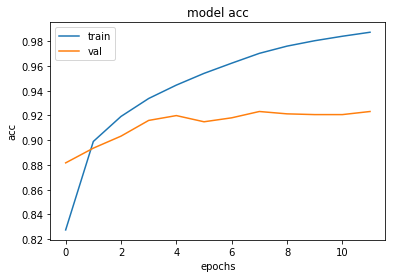

Test loss: 0.39163783426824955
Test accuracy: 0.9232


In [92]:
evaluate_model(cnn_2,history_cnn_2,x_test, z_test)

### Part 4 - Visualize wrongly predictions

#### 8) Create a function visualize_wrongly_predictions() able to show wrong prediction for each class for a given model as input. Use this function for each of the 4 previouly trained models (2 MLP, 2 CNN).

In [93]:
def visualize_wrongly_predictions(model,x_test,y_test,batch_size):
    z_pred = model.predict(x_test,batch_size,verbose=1)
    y_pred = np.argmax(z_pred,axis=1)
    for i in range(num_classes):
        plt.subplot(2, 5, i + 1)
        plt.axis('off')
        index = np.where(y_test - y_pred != 0)[0][i] #select image from different class
        plt.imshow(x_test[index,:,:,0],cmap=plt.cm.gray_r)
        plt.title('pr: %s \n tr: %s' %(class_names[y_pred[index]],class_names[y_test[index]])) #y_pred es la prediccion hecha por el modelo disenado
    plt.show()

wrongly_predictions  : MLP1
10000/10000 [==============================] - 2s 218us/step


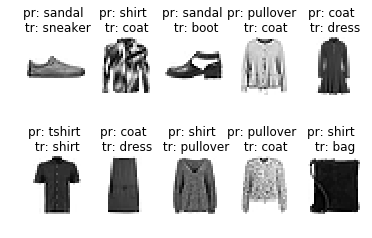

wrongly_predictions  : MLP2
10000/10000 [==============================] - 3s 258us/step


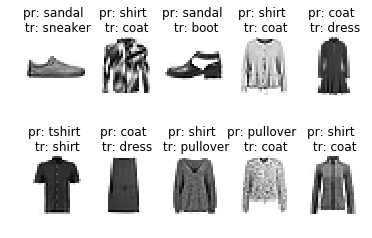

In [94]:
print("wrongly_predictions  : MLP1")
visualize_wrongly_predictions(mlp_1,x_test,y_test,batch_size)
print("wrongly_predictions  : MLP2")
visualize_wrongly_predictions(mlp_2,x_test,y_test,batch_size)


wrongly_predictions  : CNN_1
10000/10000 [==============================] - 0s 29us/step


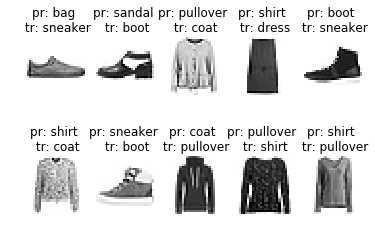

wrongly_predictions  : CNN_2
10000/10000 [==============================] - 0s 31us/step


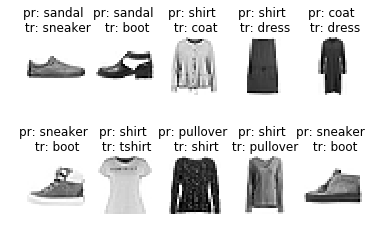

In [95]:
print("wrongly_predictions  : CNN_1")
visualize_wrongly_predictions(cnn_1,x_test,y_test,batch_size)
print("wrongly_predictions  : CNN_2")
visualize_wrongly_predictions(cnn_2,x_test,y_test,batch_size)

Comments: #todo

#### 9) Using the code given below, create a function visualize_confusion_matrix() able to display the confusion matrix  for a given model as input. Use this function for each of the 4 previouly trained models (2 MLP, 2 CNN). What is the most common confusion?

In [96]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [97]:
def visualize_confusion_matrix(model,x_test,y_test,class_names):
    z_pred = model.predict(x_test,batch_size,verbose=1)
    y_pred = np.argmax(z_pred,axis=1)
    
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='Normalized confusion matrix')
    plt.show()

confusion_matrix MLP_1
10000/10000 [==============================] - 2s 203us/step
Normalized confusion matrix


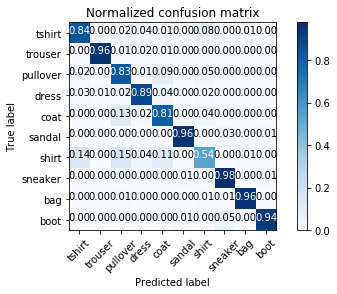

confusion_matrix MLP_2
10000/10000 [==============================] - 2s 243us/step
Normalized confusion matrix


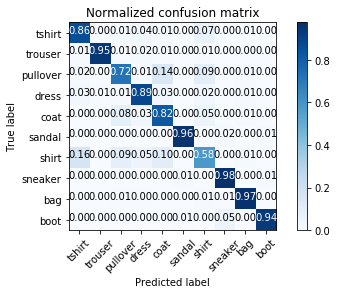

In [99]:
print("confusion_matrix MLP_1")
visualize_confusion_matrix(mlp_1, x_test,y_test,class_names)
print("confusion_matrix MLP_2")
visualize_confusion_matrix(mlp_2, x_test,y_test,class_names)

confusion_matrix CNN_1
10000/10000 [==============================] - 0s 15us/step
Normalized confusion matrix


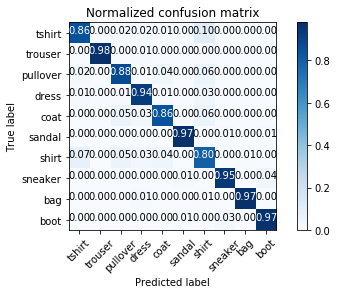

confusion_matrix CNN_2
10000/10000 [==============================] - 0s 17us/step
Normalized confusion matrix


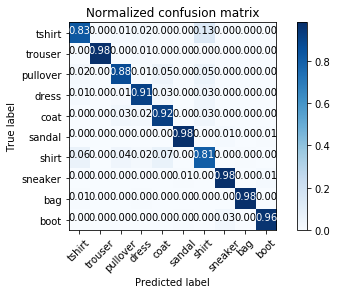

In [100]:
print("confusion_matrix CNN_1")
visualize_confusion_matrix(cnn_1, x_test,y_test,class_names)
print("confusion_matrix CNN_2")
visualize_confusion_matrix(cnn_2, x_test,y_test,class_names)

Most common confusion: *SHIRT*
# True positives
- MLP_1 : 0.54
- MLP_2 : 0.58
- CNN_1 : 0.80
- CNN_2 : 0.81


Conclusion: The CNN models offert 

### Part 5 - Data augmentation

#### 10) Based on the documentation (https://keras.io/preprocessing/image/), train one of your CNN architecture using data augmentation and conclude on the used of augmented data.

In [121]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=8,
    width_shift_range=0.08,
    height_shift_range=0.08,
    shear_range=0.3, 
    zoom_range=0.08)

datagen.fit(x_train) # compute quantities required for featurewise normalization



DA with last CNN model

In [122]:
history_cnn_2_DA = cnn_2.fit_generator(datagen.flow(x_train, z_train, batch_size=batch_size),
                    steps_per_epoch=len(x_train)/batch_size, epochs=epochs,validation_data=(x_test,z_test))

Epoch 1/12
469/468 [==============================] - 13s 28ms/step - loss: 0.2906 - acc: 0.8961 - val_loss: 0.4084 - val_acc: 0.9018
Epoch 2/12
469/468 [==============================] - 13s 28ms/step - loss: 0.2897 - acc: 0.8971 - val_loss: 0.3451 - val_acc: 0.9054
Epoch 3/12
469/468 [==============================] - 13s 27ms/step - loss: 0.2881 - acc: 0.8970 - val_loss: 0.3479 - val_acc: 0.9089
Epoch 4/12
469/468 [==============================] - 13s 28ms/step - loss: 0.2934 - acc: 0.8947 - val_loss: 0.3022 - val_acc: 0.9121
Epoch 5/12
469/468 [==============================] - 13s 28ms/step - loss: 0.2893 - acc: 0.8971 - val_loss: 0.3712 - val_acc: 0.9053
Epoch 6/12
469/468 [==============================] - 13s 27ms/step - loss: 0.2826 - acc: 0.8983 - val_loss: 0.3262 - val_acc: 0.9093
Epoch 7/12
469/468 [==============================] - 13s 27ms/step - loss: 0.2858 - acc: 0.8974 - val_loss: 0.3889 - val_acc: 0.9076
Epoch 8/12
469/468 [==============================] - 13s 28ms

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


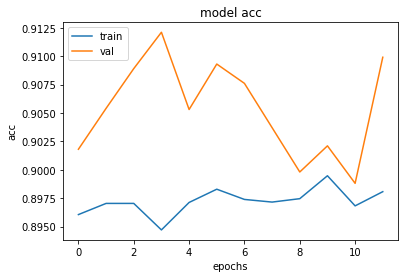

Test loss: 0.3673307552337646
Test accuracy: 0.9099


In [124]:
evaluate_model(cnn_2,history_cnn_2_DA,x_test, z_test)

confusion_matrix CNN_2
10000/10000 [==============================] - 1s 108us/step
Normalized confusion matrix


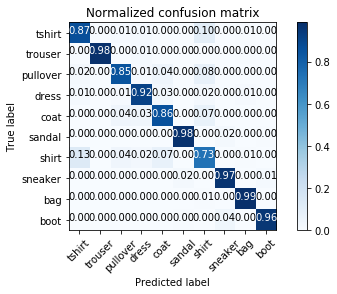

In [138]:
print("confusion_matrix CNN_2")
visualize_confusion_matrix(cnn_2, x_test,y_test,class_names)

Comment: In this model overfitting is shown, because the number of epochs is not enough. In this case we choose this value to make a comparison with the others models.

### Part 6 - Transfer learning from VGG16 trained on ImageNet

Transfer learning, is a research problem in machine learning that focuses on storing knowledge gained while solving one problem and applying it to a different but related problem.

In this part, you will do fine tuning on a pre-trained network. Fine-tuning consists in starting from a trained network, then re-training it on a new dataset using very small weight updates. To do so, you need to load a pre-trained model, add a dense classifier to compute the output, and then to freeze the weights of the pre-trained model (https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html).   

#### 11) Exploit an architecture already trained on ImageNet (https://keras.io/applications) to improve the classification results on Fashion-MNIST.

In [152]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Input,Dense, GlobalAveragePooling2D
from keras import backend as K

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# build 4D tensors
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
# data normalization
x_train = x_train.astype('float32')/x_train.max()
x_test = x_test.astype('float32')/x_test.max()
# convert class vectors to binary class matrices
z_train = keras.utils.to_categorical(y_train, num_classes)
z_test = keras.utils.to_categorical(y_test, num_classes)


base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor = Input(shape=(28, 28, 3)))

x = base_model.output
x = Flatten()(x)
# add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 10 classes
predictions = Dense(10, activation='softmax')(x)


model_inc = Model(inputs=base_model.input, outputs=predictions)

ValueError: Negative dimension size caused by subtracting 3 from 1 for 'conv2d_266/convolution' (op: 'Conv2D') with input shapes: [?,1,1,288], [3,3,288,384].

#### 12) Challenge: the first 3 teams in terms of overall test accuracy results (whatever the methodology used) will obtain bonus points!

Best accuracy reached: 0.9232

Conclusions: The best result was obtained with the model based on CNN architecture without data augmentation